In [1]:
# Importing Required Libraries

In [2]:
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from joblib import dump
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [3]:
# Importing Data

In [4]:
#Ignoring the customer file since we are recommending based on user's purchase history and considering only the Transactions file
df = pd.read_csv('/content/drive/MyDrive/DataScience/Project/Transactions (1).csv')

In [5]:
df.columns

Index(['transaction_id', 'cust_id', 'tran_date', 'prod_subcat_code',
       'prod_cat_code', 'Qty', 'Rate', 'Tax', 'total_amt', 'Store_type'],
      dtype='object')

In [6]:
df.tail()

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type
23048,94340757522,274550,25-01-2011,12,5,1,1264,132.720,1396.720,e-Shop
23049,89780862956,270022,25-01-2011,4,1,1,677,71.085,748.085,e-Shop
23050,85115299378,271020,25-01-2011,2,6,4,1052,441.840,4649.840,MBR
23051,72870271171,270911,25-01-2011,11,5,3,1142,359.730,3785.730,TeleShop
23052,77960931771,271961,25-01-2011,11,5,1,447,46.935,493.935,TeleShop


In [7]:
# dropping unwanted columns
df = df.drop('transaction_id', axis=1)
df = df.drop('tran_date', axis=1)
df = df.drop('prod_subcat_code', axis=1)
df = df.drop('Rate', axis=1)
df = df.drop('Tax', axis=1)
df = df.drop('total_amt', axis=1)
df = df.drop('Store_type', axis=1)

In [8]:
df.tail()

,cust_id,prod_cat_code,Qty
23048,274550,5,1
23049,270022,1,1
23050,271020,6,4
23051,270911,5,3
23052,271961,5,1


In [9]:
#number of rows and columns
rows, columns = df.shape
print("No of rows: ", rows)
print("No of columns: ", columns)

No of rows:  23053
No of columns:  3


In [10]:
# datatype
df.dtypes

cust_id          int64
prod_cat_code    int64
Qty              int64
dtype: object

In [11]:
df.cust_id = df.cust_id.astype(str)
df.prod_cat_code = df.prod_cat_code.astype(str)

In [12]:
df.dtypes

cust_id          object
prod_cat_code    object
Qty               int64
dtype: object

In [13]:
# No missing values
print('Number of missing values across columns-\n', df.isnull().sum())

Number of missing values across columns-
 cust_id          0
prod_cat_code    0
Qty              0
dtype: int64


In [14]:
# Summary statistics of 'Quantity'
df[['Qty']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Qty,23053.0,3.007331,1.420576,1.0,2.0,3.0,4.0,5.0


In [15]:
# minimum and maximum quantity

def min_max_quantity():
    print('The minimum quantity is: %d' %(df['Qty'].min()))
    print('The maximum quantity is: %d' %(df['Qty'].max()))

min_max_quantity()

The minimum quantity is: 1
The maximum quantity is: 5


Text(0, 0.5, 'Product code')

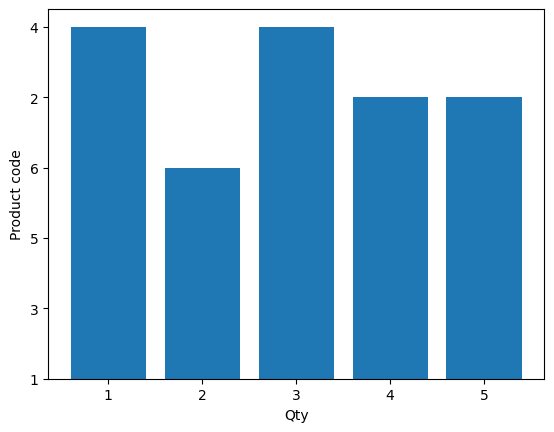

In [16]:
# Check the distribution of products bought by customers
df_sample = df.iloc[:50]
plt.bar(df_sample['Qty'],df_sample['prod_cat_code'])
plt.xlabel('Qty')
plt.ylabel('Product code')

Text(0, 0.5, 'Customer ID')

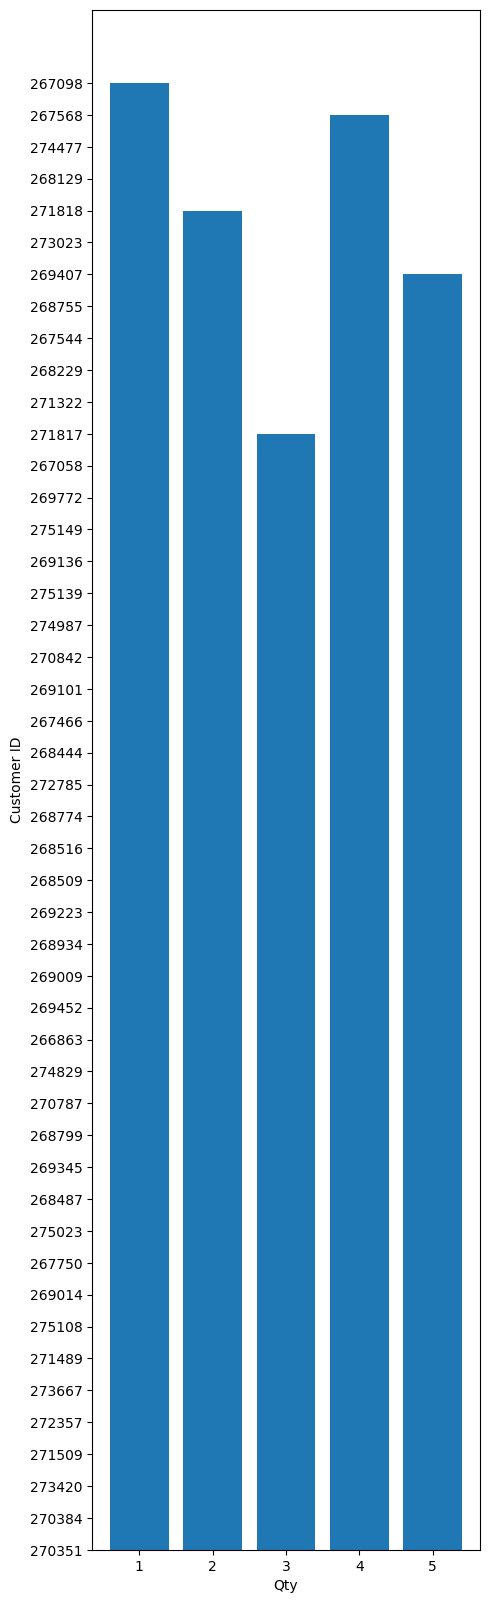

In [17]:
plt.figure(figsize=(5,20))
plt.bar(df_sample['Qty'],df_sample['cust_id'])
plt.xlabel('Qty')
plt.ylabel('Customer ID')

In [18]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['cust_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df['prod_cat_code'].nunique())

Number of unique USERS in Raw data =  5506
Number of unique ITEMS in Raw data =  6


In [19]:
# Top 10 users based on most number of items bought
most_bought = df.groupby('cust_id').size().sort_values(ascending=False)[:10]
most_bought

cust_id
269449    13
268819    13
273014    12
266794    12
272286    12
275252    12
269245    12
270831    12
268663    12
272415    12
dtype: int64

In [20]:
#Preprocessing - Taking a subset of the dataset to make it less sparse and easy to handle
counts = df['cust_id'].value_counts()
df_final = df[df['cust_id'].isin(counts[counts >= 5].index)]

In [21]:
print('Number of users who have bought 5 or more items =', len(df_final))
print('Number of unique USERS in final data = ', df_final['cust_id'].nunique())
print('Number of unique ITEMS in final data = ', df_final['prod_cat_code'].nunique())

Number of users who have bought 5 or more items = 13794
Number of unique USERS in final data =  2180
Number of unique ITEMS in final data =  6


In [22]:
# The dataframe df_final has customers who have bought 5 or more items
# We will use df_final to build recommendation systems

In [23]:
# Calculating the density of the times items most_bought
final_qty_matrix = df_final.pivot_table(index = 'cust_id', columns ='prod_cat_code', values = 'Qty').fillna(0)
print('Shape of final_qty_matrix: ', final_qty_matrix.shape)

given_num_of_qty = np.count_nonzero(final_qty_matrix)
print('given_num_of_qty = ', given_num_of_qty)
possible_num_of_qty = final_qty_matrix.shape[0] * final_qty_matrix.shape[1]
print('possible_num_of_qty = ', possible_num_of_qty)
density = (given_num_of_qty/possible_num_of_qty)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_qty_matrix:  (2180, 6)
given_num_of_qty =  7815
possible_num_of_qty =  13080
density: 59.75%


In [24]:
# Matrix with one row per 'Product' and one column per 'Customer' for Item-based collaborative filtering
final_qty_matrix.tail().T

cust_id,275249,275250,275252,275257,275261
prod_cat_code,,,,,
1,0.0,4.00,4.000000,0.0,0.000000
2,0.0,3.25,3.000000,5.0,0.000000
3,1.0,1.00,5.000000,1.0,0.000000
4,0.0,0.00,2.000000,0.0,1.000000
5,1.5,0.00,3.333333,3.0,3.666667
6,0.0,0.00,0.000000,3.0,0.000000


In [25]:
# Splitting the data randomly into train and test dataset
train_data, test_data = train_test_split(df_final, test_size = 0.3, random_state=0)

print(train_data.head(5))

      cust_id prod_cat_code  Qty
11673  272436             5    1
10891  269691             3    1
13437  269300             5    4
21972  266794             1    3
3526   271187             5    1


In [26]:
def shape():
    print("Test data shape: ", test_data.shape)
    print("Train data shape: ", train_data.shape)
shape()

Test data shape:  (4139, 3)
Train data shape:  (9655, 3)


In [27]:
# Building Collaborative Filtering Model
# Model-based Collaborative Filtering: Singular Value Decomposition

df_CF = pd.concat([train_data, test_data]).reset_index()
df_CF.tail()

,index,cust_id,prod_cat_code,Qty
13789,3583,271924,6,4
13790,5206,269332,6,2
13791,8733,273030,5,5
13792,6298,270430,4,2
13793,4841,268991,3,1


In [28]:
#User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'item'
pivot_df = df_CF.pivot_table(index = 'cust_id', columns ='prod_cat_code', values = 'Qty').fillna(0)
print(pivot_df.shape)
pivot_df.head()

(2180, 6)


prod_cat_code,1,2,3,4,5,6
cust_id,,,,,,
266783,2.0,4.000000,0.0,0.0,2.0,0.0
266785,0.0,3.750000,0.0,3.0,5.0,5.0
266794,3.5,2.500000,2.0,2.5,3.5,0.0
266806,4.0,5.000000,0.0,5.0,5.0,2.0
266809,5.0,2.666667,0.0,0.0,2.0,0.0


In [29]:
pivot_df['cust_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

prod_cat_code,1,2,3,4,5,6,cust_index
cust_id,,,,,,,
266783,2.0,4.000000,0.0,0.0,2.0,0.0,0
266785,0.0,3.750000,0.0,3.0,5.0,5.0,1
266794,3.5,2.500000,2.0,2.5,3.5,0.0,2
266806,4.0,5.000000,0.0,5.0,5.0,2.0,3
266809,5.0,2.666667,0.0,0.0,2.0,0.0,4


In [30]:
pivot_df.set_index(['cust_index'], inplace=True)

# Actual no.of items bought
pivot_df.head()

prod_cat_code,1,2,3,4,5,6
cust_index,,,,,,
0,2.0,4.000000,0.0,0.0,2.0,0.0
1,0.0,3.750000,0.0,3.0,5.0,5.0
2,3.5,2.500000,2.0,2.5,3.5,0.0
3,4.0,5.000000,0.0,5.0,5.0,2.0
4,5.0,2.666667,0.0,0.0,2.0,0.0


In [31]:
# SVD Method - SVD is useful in many tasks, such as data compression, noise reduction similar to Principal Component Analysis and
# Latent Semantic Indexing (LSI), used in document retrieval and word similarity in Text mining
from scipy.sparse.linalg import svds
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df.to_numpy(), k=5)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [32]:
all_cust_predicted_prod = np.dot(np.dot(U, sigma), Vt)

# Predicted no.of products
preds_df = pd.DataFrame(all_cust_predicted_prod, columns = pivot_df.columns)
preds_df.head()

prod_cat_code,1,2,3,4,5,6
0,2.049945,4.105225,0.048678,0.353420,1.560945,0.153981
1,-0.004121,3.741318,-0.004016,2.970841,5.036224,4.987296
2,3.516482,2.534725,2.016064,2.616631,3.355109,0.050815
3,3.915339,4.821636,-0.082513,4.400924,5.744234,1.738990
4,5.048612,2.769083,0.047379,0.343988,1.572662,0.149872


In [33]:
# Recommend the items with the highest bought products

def recommend_items(custID, pivot_df, preds_df, num_recommendations):

    cust_idx = custID-1 # index starts at 0

    # Get and sort the customer's products
    sorted_cust_prod = pivot_df.iloc[cust_idx].sort_values(ascending=False)
    #sorted_cust_products
    sorted_cust_predictions = preds_df.iloc[cust_idx].sort_values(ascending=False)
    #sorted_cust_predictions

    temp = pd.concat([sorted_cust_prod, sorted_cust_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['cust_prod', 'cust_predictions']

    temp = temp.loc[temp.cust_prod == 0]
    temp = temp.sort_values('cust_predictions', ascending=False)
    print('\nBelow are the recommended items for customer(cust_id = {}):\n'.format(custID))
    print(temp.head(num_recommendations))

In [34]:
#Enter 'custID' and 'num_recommendations' for the user #
custID = 420
num_recommendations = 2
recommend_items(custID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for customer(cust_id = 420):

                   cust_prod  cust_predictions
Recommended Items                             
6                        0.0          0.344292
1                        0.0          0.111674


In [35]:
#Evaluation
# Average ACTUAL qty for each item
final_qty_matrix.mean().head()

prod_cat_code
1    1.593310
2    1.588127
3    2.174717
4    1.126353
5    2.391940
dtype: float64

In [36]:
# Average Predicted qty for each item
preds_df.mean().head()

prod_cat_code
1    1.593176
2    1.587843
3    2.174586
4    1.125399
5    2.393126
dtype: float64

In [37]:
rmse_df = pd.concat([final_qty_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_qty', 'Avg_predicted_qty']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(6, 2)


,Avg_actual_qty,Avg_predicted_qty,item_index
prod_cat_code,,,
1,1.593310,1.593176,0
2,1.588127,1.587843,1
3,2.174717,2.174586,2
4,1.126353,1.125399,3
5,2.391940,2.393126,4


In [38]:
RMSE = round((((rmse_df.Avg_actual_qty - rmse_df.Avg_predicted_qty) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.00066 



In [39]:
# The mean squared error for the above model is 0.00066

In [40]:
final_qty_matrix.head()

prod_cat_code,1,2,3,4,5,6
cust_id,,,,,,
266783,2.0,4.000000,0.0,0.0,2.0,0.0
266785,0.0,3.750000,0.0,3.0,5.0,5.0
266794,3.5,2.500000,2.0,2.5,3.5,0.0
266806,4.0,5.000000,0.0,5.0,5.0,2.0
266809,5.0,2.666667,0.0,0.0,2.0,0.0


In [41]:
# Here, cust_id (index) is of the object data type. We will replace the cust_id by numbers, so that the index is of integer type and represents a cust id in the same format
final_qty_matrix['user_index'] = np.arange(0, final_qty_matrix.shape[0])
final_qty_matrix.set_index(['user_index'], inplace=True)

# Actual no.of items bought by customer
final_qty_matrix.head()

prod_cat_code,1,2,3,4,5,6
user_index,,,,,,
0,2.0,4.000000,0.0,0.0,2.0,0.0
1,0.0,3.750000,0.0,3.0,5.0,5.0
2,3.5,2.500000,2.0,2.5,3.5,0.0
3,4.0,5.000000,0.0,5.0,5.0,2.0
4,5.0,2.666667,0.0,0.0,2.0,0.0


In [42]:
# Function to find Similar users and their similarity scores
# defining a function to get similar users
def similar_users(user_index, interactions_matrix):
    similarity = []
    for user in range(0, interactions_matrix.shape[0]): #  .shape[0] gives number of rows

        #finding cosine similarity between the user_id and each user
        sim = cosine_similarity([interactions_matrix.loc[user_index]], [interactions_matrix.loc[user]])

        #Appending the user and the corresponding similarity score with user_id as a tuple
        similarity.append((user,sim))

    similarity.sort(key=lambda x: x[1], reverse=True)
    most_similar_users = [tup[0] for tup in similarity] #Extract the user from each tuple in the sorted list
    similarity_score = [tup[1] for tup in similarity] ##Extracting the similarity score from each tuple in the sorted list

    #Remove the original user and its similarity score and keep only other similar users
    most_similar_users.remove(user_index)
    similarity_score.remove(similarity_score[0])

    return most_similar_users, similarity_score

In [43]:
similarity = similar_users(3,final_qty_matrix)[0][0:10]
similarity

[1990, 1326, 1743, 585, 1121, 53, 802, 956, 1954, 73]

In [44]:
#Print the similarity score
similar_users(3,final_qty_matrix)[1][0:10]

[array([[0.98857742]]),
 array([[0.98020378]]),
 array([[0.97654391]]),
 array([[0.97242688]]),
 array([[0.96840025]]),
 array([[0.96695234]]),
 array([[0.96645491]]),
 array([[0.96581236]]),
 array([[0.96200673]]),
 array([[0.9617419]])]

In [45]:
# Finding out top 10 similar users to the user index 1231 and their similarity score
similarity = similar_users(1231,final_qty_matrix)[0][0:10]
similarity

[1103, 583, 1377, 1356, 909, 120, 1608, 561, 2052, 2170]

In [46]:
#Print the similarity score
similar_users(1231,final_qty_matrix)[1][0:10]

[array([[0.99770243]]),
 array([[0.99520371]]),
 array([[0.99520371]]),
 array([[0.99494253]]),
 array([[0.99487439]]),
 array([[0.9944175]]),
 array([[0.99332514]]),
 array([[0.99305078]]),
 array([[0.9922143]]),
 array([[0.99111333]])]

In [47]:
#Function to recommend products
# defining the recommendations function to get recommendations by using the similar users' preferences
def recommendations(user_index, num_of_products, interactions_matrix):

    #Saving similar users using the function similar_users defined above
    most_similar_users = similar_users(user_index, interactions_matrix)[0]

    #Finding product IDs with which the cust_id has interacted
    prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    recommendations = []

    observed_interactions = prod_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:

            #Finding 'n' products which have been bought by similar users but not by the cust_id
            similar_user_prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_prod_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_prod_ids)
        else:
            break

    return recommendations[:num_of_products]

In [48]:
# Recommend 3 products to user index 1542 based on similarity based collaborative filtering
recommendations(1542,3,final_qty_matrix)

['2', '6', '4']

In [49]:
# Recommend 3 products to user index 1231 based on similarity based collaborative filtering
recommendations(1231,3,final_qty_matrix)

['4', '2', '1']

In [50]:
!pip install streamlit --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.0 MB/s eta 0:00:00


In [51]:
import pickle
pickle.dump(df,open('Cust_list,pkl','wb'))
pickle.dump(similarity,open('similarity.pkl','wb'))

In [52]:
%%writefile app.py
import streamlit as st
import pickle
import requests

prod_ids=pickle.load(open('Cust_list,pkl','rb'))
similarity=pickle.load(open('similarity.pkl','rb'))

def recommendations(user_index, num_of_products, interactions_matrix):

    most_similar_users = similar_users(user_index, interactions_matrix)[0]

    prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[user_index] > 0)]))
    recommendations = []
    similar_user=1
    observed_interactions = prod_ids.copy()
    for similar_user in most_similar_users:
        if len(recommendations) < num_of_products:

            similar_user_prod_ids = set(list(interactions_matrix.columns[np.where(interactions_matrix.loc[similar_user] > 0)]))
            recommendations.extend(list(similar_user_prod_ids.difference(observed_interactions)))
            observed_interactions = observed_interactions.union(similar_user_prod_ids)
        else:
            break

    return recommendations[:num_of_products]

st.header("Product Recommender System")
Product_list=prod_ids
selected_product=st.selectbox("Type or select a customer from the dropdown",prod_ids,index=None)

if st.button("Show Recommendations"):
    user_index = 'Any'
    interactions_matrix = 'Any'

    similar_user_prod_ids = recommendations(user_index, num_of_products=5, interactions_matrix=interactions_matrix)
    st.write("Recommended Products:", similar_user_prod_ids)

Writing app.py


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.122.1.9:8501

npx: installed 22 in 5.487s
your url is: https://every-steaks-hunt.loca.lt
